In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Import Python Modules

In [2]:
import time

# Main PODPAC library
import podpac

# Data source nodes
from podpac.datalib.smap_egi import SMAP
from podpac.datalib.drought_monitor import DroughtMonitorCategory, DroughtCategory

# Algorithm nodes
from podpac.algorithm import TransformTimeUnits, Arithmetic

# Retrieve Data 
## Computed Drought Categories
* We computed these categories from historical SMAP data and staged the results on AWS S3. 
* To access these datasets, our specific AWS credentials are required.

In [3]:
# AWS bucket where data lives
bucket = "podpac-drought-monitor-s3"
# Name of the file, in 'zarr' format
cats_time = "SMAP_CATS_2.zarr"
cats_space = "SMAP_CATS_CHUNKED.zarr"
# Path used by PODPAC to retrieve the data
source = 's3://{bucket}/{zarr_file}'.format(bucket=bucket, zarr_file=cats_space)

# Create the node that points to the .zarr file on S3
# cats = DroughtMonitorCategory(datakey='d0', source=source)
d0_src = DroughtMonitorCategory(source=source, data_key='d0')

In [4]:
# Test coordinates
coords_time = d0_src.coordinates[301, 1000, :]
coords_space = d0_src.coordinates[200:400, 900:1100, 128]

coords_time2 = podpac.coordinates.merge_dims(
    [coords_time.drop('time'), podpac.Coordinates([podpac.crange('2019-01-01', '2019-05-19', '1,D', 'time')])])
coords_space2 = podpac.coordinates.merge_dims(
    [coords_space.drop('time'), podpac.Coordinates(['2019-05-19'], ['time'])])

In [5]:
# start = time.time()
# ot = d0_src.eval(coords_time)
# print("ot: {}".format(time.time()-start))

# start = time.time()
# os = d0_src.eval(coords_space)
# print("os: {}".format(time.time()-start))
# os.plot()
# figure()
# ot.plot()

In [6]:
# All of our data uses the 'dayofyear' to describe the climatology. 
# Hence, any incoming requests should have the 'time' unit transformed to 'dayofyear'
time_units = 'dayofyear'

# This algorithm node take the incoming request, replaces the yTransformTimeUnits by 2018, evaluates the d0_source node, 
# then substitutes the original date in the result
d0 = TransformTimeUnits(source=d0_src, time_units=time_units, substitute_eval_coords=True)

# Repeat for the other categories
d1 = TransformTimeUnits(source=DroughtMonitorCategory(data_key='d1', source=source), time_units=time_units, substitute_eval_coords=True)
d2 = TransformTimeUnits(source=DroughtMonitorCategory(data_key='d2', source=source), time_units=time_units, substitute_eval_coords=True)
d3 = TransformTimeUnits(source=DroughtMonitorCategory(data_key='d3', source=source), time_units=time_units, substitute_eval_coords=True)
d4 = TransformTimeUnits(source=DroughtMonitorCategory(data_key='d4', source=source), time_units=time_units, substitute_eval_coords=True)

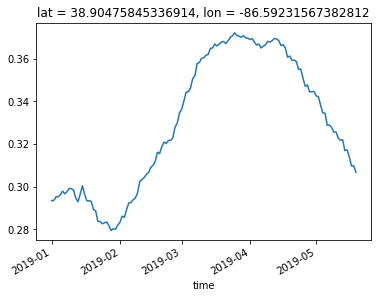

In [7]:
# Test
ot2 = d0.eval(coords_time2)
ot2.plot()

## Raw SMAP Soil Moisture Data
* We retrieve this data from NSIDC through the EGI (Earthdata Gateway Interface). 
* We retrieve level 3 data that have AM and PM returns, and we composite them together.

In [8]:
smap_file = 'SMAP_CHUNKED32.zarr'
smap_source = 's3://{bucket}/{smap_file}'.format(bucket=bucket, smap_file=smap_file)

kwargs = {
    'source': smap_source,
    'crs': 'epsg:4326', 'nan_vals': [-9999],
    'interpolation':{
        'method': 'nearest',
        'params': {
              'time_tolerance': np.timedelta64(1, 'D')
        }
    }
}
smap_e_am_raw = podpac.data.Zarr(data_key='Soil_Moisture_Retrieval_Data_AM/soil_moisture', **kwargs)
smap_e_am_qf = podpac.data.Zarr(data_key='Soil_Moisture_Retrieval_Data_AM/retrieval_qual_flag', **kwargs)
smap_e_am = podpac.algorithm.Mask(source=smap_e_am_raw, mask=smap_e_am_qf, bool_op='>', bool_val=1, in_place=True)
smap_e = podpac.algorithm.ExpandCoordinates(source=smap_e_am, time=("-8,D", "0,D", "1,D"))
smap = podpac.algorithm.Mean(source=smap_e, dims="time", style=d0_src.style)

In [9]:
# Test 
o_smap = smap.eval(coords_space2)
o_smap_e = smap_e_am.eval(coords_time2)

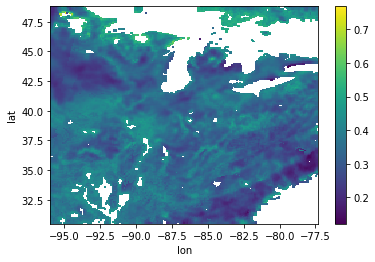

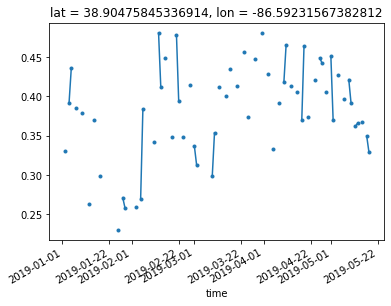

In [10]:
o_smap.plot()
figure()
o_smap_e.plot(marker='.')

# Create algorithm to convert raw SMAP data to drought categories
* We use an Arithmetic node computes pixel-wise results using an arbitrary equation
* The inputs come from the previously-created nodes, with an A, B, C,... naming convention

In [11]:
# Create the drought Categorization algorithm
cats_space = DroughtCategory(soil_moisture=smap, d0=d0, d1=d1, d2=d2, d3=d3, d4=d4)
cats_time = DroughtCategory(soil_moisture=smap_e_am, d0=d0, d1=d1, d2=d2, d3=d3, d4=d4)

In [12]:
cats_o = cats_space.eval(coords_space2)
catt_o = cats_time.eval(coords_time2)

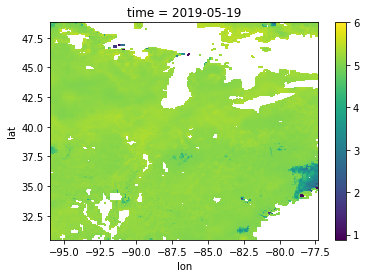

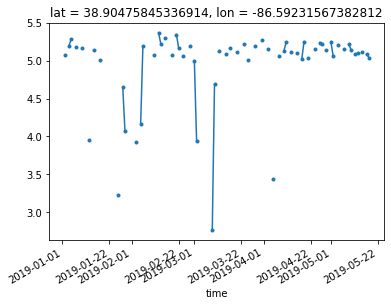

In [13]:
cats_o.plot()
figure()
catt_o.plot(marker='.')

# Get the datasource for the Mask of the US


In [14]:
mask_us = podpac.data.Zarr(data_key='maskUS', source=smap_source)

In [15]:
o_m = mask_us.eval(coords_space2)

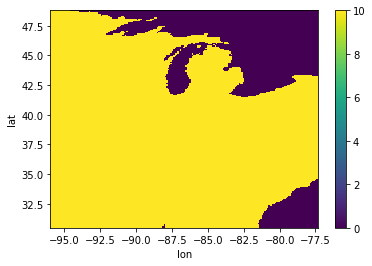

In [16]:
o_m.plot()

In [17]:
cats_space_us = podpac.algorithm.Mask(source=cats_space, mask=mask_us, bool_op='<', bool_val=10, in_place=True,
                                     style=cats_space.style)

In [18]:
coords = podpac.Coordinates([podpac.clinspace(20, 75, 180), podpac.clinspace(-130,-65, 180), '2019-05-19'], ['lat', 'lon', 'time'], crs='EPSG:4269')
o_cm = podpac.Node.from_json(cats_space_us.json).eval(coords)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


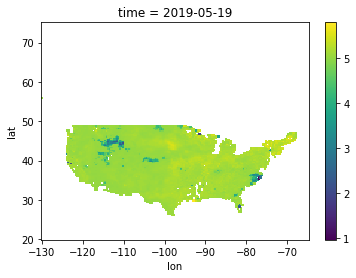

In [19]:
o_cm.plot()

# Export PODPAC Pipelines for development of website
* **Note**, PODPAC kept track of all the nodes used to create the analysis, and recorded this in a light-weight JSON format

In [20]:
def save_json(node, filename):
    with open(filename, 'w') as fid:
        fid.write(node.json_pretty)
        
save_json(d0, 'pipeline_d0.json')
save_json(d1, 'pipeline_d1.json')
save_json(d2, 'pipeline_d2.json')
save_json(d3, 'pipeline_d3.json')
save_json(d4, 'pipeline_d4.json')
save_json(cats_space, 'pipeline_category_space.json')
save_json(cats_space_us, 'pipeline_category_space_us.json')
save_json(cats_time, 'pipeline_category_time.json')
save_json(smap, 'pipeline_moisture_space.json')
save_json(smap_e_am, 'pipeline_moisture_time.json')

print (cats_space_us.json_pretty)

{
    "Zarr": {
        "node": "core.data.zarr_source.Zarr",
        "attrs": {
            "alt_key": "alt",
            "cf_calendar": null,
            "cf_time": false,
            "cf_units": null,
            "crs": null,
            "data_key": "maskUS",
            "interpolation": "nearest",
            "lat_key": "lat",
            "lon_key": "lon",
            "skip_validation": false,
            "source": "s3://podpac-drought-monitor-s3/SMAP_CHUNKED32.zarr",
            "time_key": "time"
        },
        "inputs": {
            "boundary": {},
            "nan_vals": []
        }
    },
    "DroughtMonitorCategory": {
        "node": "datalib.drought_monitor.DroughtMonitorCategory",
        "attrs": {
            "alt_key": "alt",
            "cf_calendar": null,
            "cf_time": false,
            "cf_units": null,
            "crs": null,
            "data_key": "d0",
            "interpolation": "nearest",
            "lat_key": "lat",
            "lon_key": "